In [43]:
%reset -f
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from wavhandler import *
from utils import *
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, BatchNormalization
from keras.models import Model
from keras import backend as K

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [44]:
dataset = Dataset('LG')
dataset.load(only_names=False)
target_names = dataset.target_classes
X_names = dataset.filenames
y = dataset.y
X = dataset.X
print("X_shape:", X.shape)
print("y_shape:", y.shape)

100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


X_shape: (12746, 5000)
y_shape: (12746,)


In [45]:
%%time
# X = make_df_parallel(names=X_names, setting='psd_dB')
X = transform_data(dataset.X)

100%|██████████| 12746/12746 [00:06<00:00, 1868.58it/s]

CPU times: user 54.6 s, sys: 0 ns, total: 54.6 s
Wall time: 6.83 s


In [57]:
from sklearn.preprocessing import MinMaxScaler

X_std = X
# X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
X_std = MinMaxScaler(feature_range=(0,1)).fit_transform(X)

X, y = shuffle(X_std, y, random_state=3)
#del df

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=2018)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape, x_test.shape)

(12108, 129, 1) (638, 129, 1)


In [58]:
# input_dim = x_train.shape[1]
# encoding_dim = 2
# input_img = Input(batch_shape=(None,5000,1))
# # encoder = Conv1D(256,3, activation='relu', padding='same')(input_img)
# # encoder = Conv1D(256,3, activation='relu', padding='same')(encoder)
# # encoder = MaxPooling1D(2)(encoder)
# # encoder = Conv1D(128,3, activation='relu', padding='same')(input_img)
# # encoder = Conv1D(128,3, activation='relu', padding='same')(encoder)
# # encoder = MaxPooling1D(2)(encoder)
# encoder = Conv1D(64,3, activation='relu', padding='same')(input_img)
# encoder = Conv1D(64,3, activation='relu', padding='same')(encoder)
# encoder = MaxPooling1D(2)(encoder)
# encoder = Conv1D(32,3, activation='relu', padding='same')(encoder)
# encoder = Conv1D(32,3, activation='relu', padding='same')(encoder)
# # encoder = BatchNormalization()(encoder)
# encoder = MaxPooling1D(2)(encoder)
# encoder = Conv1D(16,3, activation='relu', padding='same')(encoder)
# encoder = Conv1D(16,3, activation='relu', padding='same')(encoder)
# encoder = MaxPooling1D(2)(encoder)

# encoder = Dense(encoding_dim, activation='relu')(encoder)

# decoder = Conv1D(16, 3, activation='relu', padding='same')(encoder)
# decoder = Conv1D(16, 3, activation='relu', padding='same')(decoder)
# decoder =  UpSampling1D(2)(decoder)
# decoder = Conv1D(32, 3, activation='relu', padding='same')(decoder)
# decoder = Conv1D(32, 3, activation='relu', padding='same')(decoder)
# decoder =  UpSampling1D(2)(decoder)
# # decoder = BatchNormalization()(decoder)
# decoder = Conv1D(64, 3, activation='relu', padding='same')(decoder)
# decoder = Conv1D(64, 3, activation='relu', padding='same')(decoder)
# decoder =  UpSampling1D(2)(decoder)
# # decoder = Conv1D(128, 3, activation='relu', padding='same')(decoder)
# # decoder = Conv1D(128, 3, activation='relu', padding='same')(decoder)
# # decoder =  UpSampling1D(2)(decoder)
# # decoder = Conv1D(256, 3, activation='relu', padding='same')(decoder)
# # decoder = Conv1D(256, 3, activation='relu', padding='same')(decoder)
# # decoder =  UpSampling1D(2)(decoder)
# decoder = Conv1D(1, 3, activation='sigmoid', padding='same')(decoder)
# autoencoder = Model(input_img, decoder)
# autoencoder.compile(optimizer='adam', loss='mse')
# print(autoencoder.summary())

In [59]:
# x_train = np.expand_dims(x_train, axis=-1)
# y_train = np.expand_dims(y_train, axis=-1)
# # print(x_train.shape, y_train.shape)

In [60]:
# # ENCODER

input_sig = Input(batch_shape=(None,129,1))
x = Conv1D(64,3, activation='relu', padding='valid')(input_sig)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(32,3, activation='relu', padding='valid')(x1)
x3 = MaxPooling1D(2)(x2)
flat = Flatten()(x3)
encoded = Dense(32,activation = 'relu')(flat)
 
print("shape of encoded {}".format(K.int_shape(encoded)))
 
# DECODER 
x2_ = Conv1D(32, 3, activation='relu', padding='valid')(x3)
x1_ = UpSampling1D(2)(x2_)
x_ = Conv1D(64, 3, activation='relu', padding='valid')(x1_)
upsamp = UpSampling1D(2)(x_)
flat = Flatten()(upsamp)
decoded = Dense(129,activation = 'relu')(flat)
decoded = Reshape((129,1))(decoded)
 
print("shape of decoded {}".format(K.int_shape(decoded)))
 
autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

shape of encoded (None, 32)
shape of decoded (None, 129, 1)


In [61]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
callbacks_list = [EarlyStopping(monitor = 'loss', patience = 3, verbose = 1), 
                  ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 3, verbose = 1)]

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
#                 shuffle=True,
                verbose = 1,
                callbacks=callbacks_list)

Epoch 1/100
12108/12108 [==============================] - 13s 1ms/step - loss: 0.7075 - acc: 1.4853e-04
Epoch 2/100
12108/12108 [==============================] - 5s 377us/step - loss: 0.5315 - acc: 1.5238e-04
Epoch 3/100
12108/12108 [==============================] - 5s 379us/step - loss: 0.5266 - acc: 1.5238e-04
Epoch 4/100
12108/12108 [==============================] - 5s 387us/step - loss: 0.5263 - acc: 1.5302e-04
Epoch 5/100
12108/12108 [==============================] - 5s 392us/step - loss: 0.5258 - acc: 1.5302e-04
Epoch 6/100
12108/12108 [==============================] - 5s 388us/step - loss: 0.5252 - acc: 1.5302e-04
Epoch 7/100
12108/12108 [==============================] - 5s 387us/step - loss: 0.5248 - acc: 1.5302e-04
Epoch 8/100
12108/12108 [==============================] - 5s 386us/step - loss: 0.5245 - acc: 1.5302e-04
Epoch 9/100
12108/12108 [==============================] - 5s 389us/step - loss: 0.5255 - acc: 1.5302e-04
Epoch 10/100
12108/12108 [=====================

KeyboardInterrupt: 

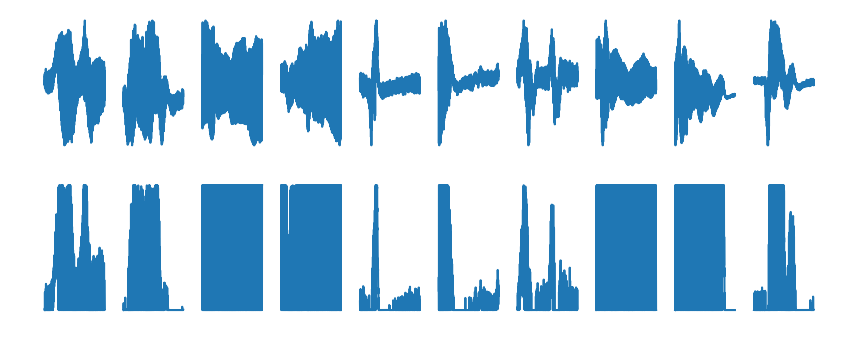

In [22]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x_test[i])
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.plot(decoded_imgs[i])
    plt.gray()
    ax.set_axis_off()

plt.show()

In [23]:

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

# save latent space features 128-d vector
pickle.dump(encoded_imgs, open('conv_autoe_features.pickle', 'wb'))

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.set_axis_off()

plt.show()

NameError: name 'encoded' is not defined

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x_test[i])#.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_imgs[i])#.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 0.0469 loss with bs=128 and encoding_dim=15 